# Question 3

In [70]:
# libraries
import wbgapi as wb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [71]:
def format_cientific_number(num):
    num_str = "{:.2e}".format(num)


    mantissa, exponent = num_str.split('e')


    first_two_digits = mantissa[:3]
    return first_two_digits+'e'+exponent


## Adding more information to the data frame

In [72]:
indicators = {
    'EG.USE.COMM.CL.ZS': 'Alternative and nuclear energy (% of total energy use)',
    'IS.VEH.NVEH.P3': 'vehicles_per_capita',
    'EG.FEC.RNEW.ZS': 'renewable_energy_percentage',
    'EG.USE.COMM.FO.ZS': 'fossil_fuel_energy_percentage',
    'EG.USE.ELEC.ZS': 'electricity_used_in_transport'
}
df=wb.data.DataFrame(indicators, mrnev=1, labels = True)
df=df.rename(columns=indicators)
df=df.drop(df.index[[i for i in range(48)]])
df.set_index('Country', inplace=True)
file_path = 'co2_emissions.csv'
dt2=pd.read_csv(file_path,index_col='Country')
df = df.join(dt2)

### Using KNN to substitue NaN- values

In [73]:
imputer = KNNImputer(n_neighbors=2)
imputed_array = imputer.fit_transform(df)
df= pd.DataFrame(imputed_array, columns=df.columns, index=df.index)
df.head()
df.to_csv('co2_emissions2.csv')

### Correlations between the columns

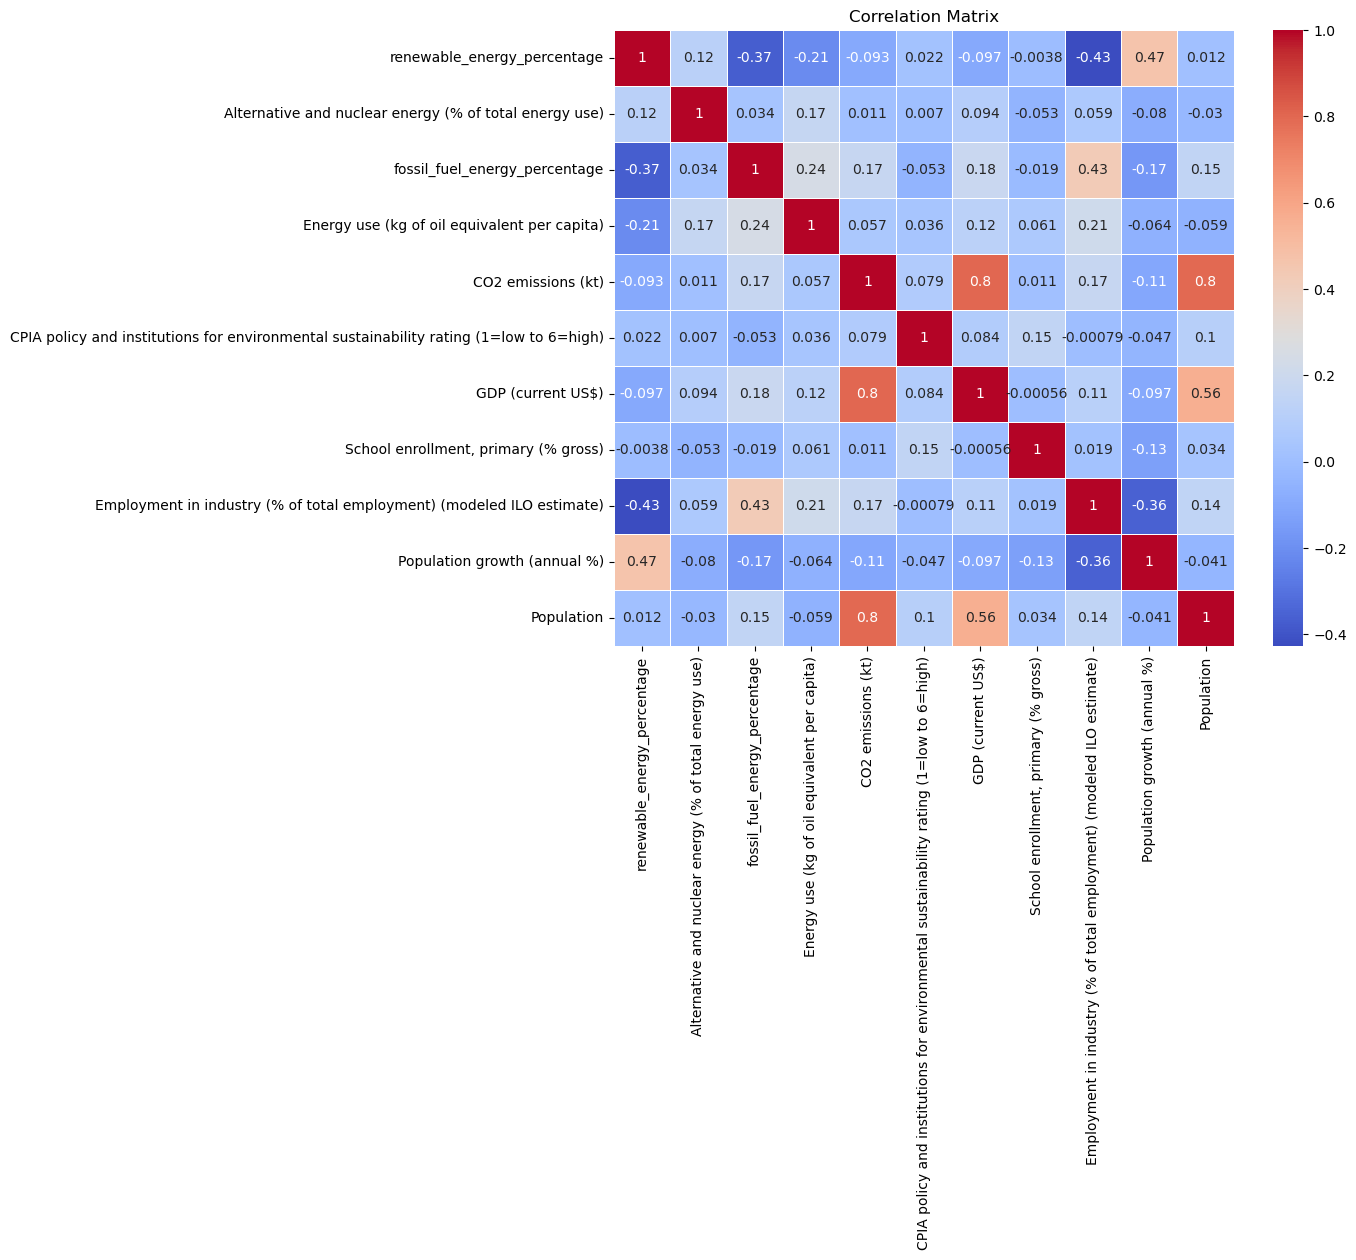

In [74]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))  # Ajusta el tamaño de la figura
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Linear regression

In [75]:
X = df.drop('CO2 emissions (kt)', axis=1)  
y = df['CO2 emissions (kt)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [77]:
y_pred = model.predict(X_test)

### Testing the model

In [78]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1227184013636.9607
R-squared: -9.464247998958397


In [79]:
x = df['renewable_energy_percentage']
y = df['CO2 emissions (kt)']
y2 = model.predict(X)
y3 = [df['CO2 emissions (kt)'].mean() for i in range(len(df['CO2 emissions (kt)']))]
names = df.index


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y,
    mode='markers',
    marker=dict(size=10, color='skyblue'),
    text=names,
    hoverinfo='text',
    name='Real data'
))

fig.add_trace(go.Scatter(
    x=x, y=y2,
    mode='markers',
    marker=dict(size=10, color='red'),
    text=names,
    hoverinfo='text',
    name='Predicted values'
))

fig.add_trace(go.Scatter(
    x=x, y=y3,
    mode='markers',
    marker=dict(size=10, color='green'),
    text=names,
    hoverinfo='text',
    name='Mean value'
))


fig.update_layout(
    title='CO emmisions per Country',
    xaxis=dict(
        title='',
        showticklabels=True  # Ocultar etiquetas del eje x
    ),
    xaxis_title='Renewable Energy Percentage',
    yaxis_title='CO2 emmisions (kT)',
)

fig.write_html("CO2 emissions errors (renew).html")
#fig.write_image('a.png', width=800, height=600)
fig.show()

## Hypothesis: renewable energy increase by 50%

In [80]:
df['renewable_energy_percentage'].describe()

count    213.000000
mean      28.978780
std       27.180719
min        0.000000
25%        7.500000
50%       20.200000
75%       45.900000
max       96.300000
Name: renewable_energy_percentage, dtype: float64

In [81]:
df.loc[df['renewable_energy_percentage'] < 50, 'renewable_energy_percentage'] = 50

In [82]:
X = df.drop('CO2 emissions (kt)', axis=1)

In [83]:
y_pred=model.predict(X)

In [84]:
df['CO2 Emissions predicted']=y_pred

## Analyzing the problems

In [85]:
df['delta CO2 Emissions']=(y_pred-df['CO2 emissions (kt)'])

In [86]:
total=df['delta CO2 Emissions']<0
total2 = y_pred <0

In [87]:
print(f'Countries where the linear regression crashes {total2.sum()}')
print(f'Countries where the increase of renewable energy percentage is projected to be succesful {total.sum()-total2.sum()}')

Countries where the linear regression crashes 133
Countries where the increase of renewable energy percentage is projected to be succesful 28


In [88]:
df_filtrado = df[df['CO2 Emissions predicted'] >0.0]
df_filtrado= df_filtrado[ df_filtrado['CO2 Emissions predicted']<df_filtrado['CO2 emissions (kt)']]

In [89]:
df_filtrado.shape
df_filtrado['delta CO2 Emissions']=df_filtrado['delta CO2 Emissions'].apply(abs)
df_filtrado['delta CO2 Emissions']=df_filtrado['delta CO2 Emissions'].apply(format_cientific_number)

In [90]:
x = df_filtrado.index
y = df_filtrado['CO2 Emissions predicted']
y2= df_filtrado['CO2 emissions (kt)']
names = 'Reduction '+df_filtrado['delta CO2 Emissions'] +'kt'


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y,
    mode='lines+markers',
    marker=dict(size=10, color='skyblue'),
    text=names,
    hoverinfo='text',
    name='Prediction'
))

fig.add_trace(go.Scatter(
    x=x, y=y2,
    mode='lines+markers',
    marker=dict(size=10, color='red'),
    hoverinfo='text',
    name='Current CO2 emissions'
))



fig.update_layout(
    title='CO emmisions per succesful country',
    xaxis=dict(
        title='',
        showticklabels=True  
    ),
    xaxis_title='Country',
    yaxis_title='CO2 emmisions (kT)',
)

fig.write_html("Succesful countries CO2 emissions comparison(energy renewale).html")
#fig.write_image('d.png', width=800, height=600)
fig.show()
